In [662]:
import os
import numpy as np
import scipy.ndimage
import skimage.feature
import cv2
from PIL import Image
from sklearn import decomposition
import matplotlib.pyplot as plt
%matplotlib inline

In [551]:
bgr_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('imgs/'))]
gray_imgs = [cv2.imread(f'imgs/{name}', cv2.IMREAD_GRAYSCALE) for name in sorted(os.listdir('imgs/'))]

hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in bgr_imgs] 
hls_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HLS) for img in bgr_imgs] 
yuv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in bgr_imgs]
luv_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2LUV) for img in bgr_imgs]
lab_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in bgr_imgs]
ycrcb_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB) for img in bgr_imgs]

In [371]:
# https://stackoverflow.com/questions/55353735/how-to-do-alpha-matting-in-python
import numpy.linalg
import scipy.sparse
import scipy.sparse.linalg
from PIL import Image
from tqdm import tqdm_notebook as tqdm
#from numba import njit

def alpha_matting(img, trimap):
    # configure paths here
    #image_path  = "cat_image.png"
    #trimap_path = "cat_trimap.png"
    #alpha_path  = "cat_alpha.png"
    #cutout_path = "cat_cutout.png"

    # load and convert to [0, 1] range
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
    trimap = trimap/255.0

    # make matting laplacian
    i,j,v = closed_form_laplacian(img)
    h,w = trimap.shape
    L = scipy.sparse.csr_matrix((v, (i, j)), shape=(w*h, w*h))

    # build linear system
    A, b = make_system(L, trimap)

    # solve sparse linear system
    print("solving linear system...")
    alpha = scipy.sparse.linalg.spsolve(A, b).reshape(h, w)

    # stack rgb and alpha
    cutout = np.concatenate([img, alpha[:, :, np.newaxis]], axis=2)

    # clip and convert to uint8 for PIL
    cutout = np.clip(cutout*255, 0, 255).astype(np.uint8)
    alpha  = np.clip( alpha*255, 0, 255).astype(np.uint8)

    return alpha, cutout

def closed_form_laplacian(image, epsilon=1e-7, r=1):
    h,w = image.shape[:2]
    window_area = (2*r + 1)**2
    n_vals = (w - 2*r)*(h - 2*r)*window_area**2
    k = 0
    # data for matting laplacian in coordinate form
    i = np.empty(n_vals, dtype=np.int32)
    j = np.empty(n_vals, dtype=np.int32)
    v = np.empty(n_vals, dtype=np.float64)

    # for each pixel of image
    for y in tqdm(range(r, h - r)):
        for x in range(r, w - r):

            # gather neighbors of current pixel in 3x3 window
            n = image[y-r:y+r+1, x-r:x+r+1]
            u = np.zeros(3)
            for p in range(3):
                u[p] = n[:, :, p].mean()
            c = n - u

            # calculate covariance matrix over color channels
            cov = np.zeros((3, 3))
            for p in range(3):
                for q in range(3):
                    cov[p, q] = np.mean(c[:, :, p]*c[:, :, q])

            # calculate inverse covariance of window
            inv_cov = np.linalg.inv(cov + epsilon/window_area * np.eye(3))

            # for each pair ((xi, yi), (xj, yj)) in a 3x3 window
            for dyi in range(2*r + 1):
                for dxi in range(2*r + 1):
                    for dyj in range(2*r + 1):
                        for dxj in range(2*r + 1):
                            i[k] = (x + dxi - r) + (y + dyi - r)*w
                            j[k] = (x + dxj - r) + (y + dyj - r)*w
                            temp = c[dyi, dxi].dot(inv_cov).dot(c[dyj, dxj])
                            v[k] = (1.0 if (i[k] == j[k]) else 0.0) - (1 + temp)/window_area
                            k += 1
        # print("generating matting laplacian", y - r + 1, "/", h - 2*r)

    return i, j, v

def make_system(L, trimap, constraint_factor=100.0):
    # split trimap into foreground, background, known and unknown masks
    is_fg = (trimap > 0.9).flatten()
    is_bg = (trimap < 0.1).flatten()
    is_known = is_fg | is_bg
    is_unknown = ~is_known

    # diagonal matrix to constrain known alpha values
    d = is_known.astype(np.float64)
    D = scipy.sparse.diags(d)

    # combine constraints and graph laplacian
    A = constraint_factor*D + L
    # constrained values of known alpha values
    b = constraint_factor*is_fg.astype(np.float64)

    return A, b

In [3]:
def em_color(img, ncolors=3):
    raw = img.reshape(-1,3)
    em = cv2.ml.EM_create()
    em.setClustersNumber(ncolors)
    em.trainEM(raw)
    means = em.getMeans()
    covs = em.getCovs()
    (r, prob) = em.predict(raw.astype(np.float32))
    colors = np.argmax(prob, axis=1).reshape(img.shape[:2])
    return colors

In [488]:
def grab_cut(img, mask=None, color_space_transform=cv2.COLOR_BGR2YUV):
    cv2.setRNGSeed(42)
    (h,w) = img.shape[:2] 
    bgdModel = np.zeros((1,13*5),np.float64) 
    fgdModel = np.zeros((1,13*5),np.float64) 
    tr_img = cv2.cvtColor(img, color_space_transform)
    
    if mask is None:
        margin_width = 25
        margin_height = 15
        mask = np.zeros((h,w),np.uint8)
        rect = (margin_width,margin_height,w-2*margin_width,h-margin_height)
        mask, _, _= cv2.grabCut(tr_img,mask,rect,bgdModel,fgdModel,2,cv2.GC_INIT_WITH_RECT)
    else:
        mask = mask.copy()
        mask, _, _= cv2.grabCut(tr_img,mask,None,bgdModel,fgdModel,2,cv2.GC_INIT_WITH_MASK)

    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    
    new_mask = np.zeros_like(mask)
    cv2.drawContours(new_mask, [cnt], 0, 255, thickness=cv2.FILLED)
    return new_mask

In [365]:
def get_eroded_mask(mask, kernel, iterations):
    mask = mask.copy()
    mask[0,:] = 0
    mask[-1, :] = 0
    mask[:, 0] = 0
    mask[:, -1] = 0
    eroded_mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel, iterations=iterations)
    return eroded_mask

In [5]:
def grab_cut_iter(imgs, masks, color_space_transform=cv2.COLOR_BGR2YUV):
    gaus_kernel = (7,7) # (7,7)
    sigma = 3 #3
    
    dilation_kernel = np.ones((11,11),np.uint8)
    dilation_iterations = 2
    
    erosion_kernel = np.ones((11,11),np.uint8)
    erosion_iterations = 2
    
    dilated_masks = [cv2.morphologyEx(mask, cv2.MORPH_DILATE, dilation_kernel, iterations=dilation_iterations) for mask in masks]
    eroded_masks = [get_eroded_mask(mask, erosion_kernel, erosion_iterations) for mask in masks]

    forwarded_masks = []
    for dilated_mask, eroded_mask in zip(dilated_masks, eroded_masks):
        mask = dilated_mask.copy()
        mask[dilated_mask == 255] = 2 # probable background
        mask[eroded_mask == 255] = 3 # probable foreground
        forwarded_masks.append(mask)
    
    imgs = [cv2.GaussianBlur(img, gaus_kernel, sigma) for img in imgs]
    new_masks = [grab_cut(img, mask, color_space_transform) for img, mask in zip(imgs, forwarded_masks)]
        
    return new_masks

In [686]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

def super_pixel(n_segments=10, sigma=1, compactness=10):
    plt.figure(figsize=(20,15))
    for k in range(6):
        img = cv2.cvtColor(bgr_imgs[k], cv2.COLOR_BGR2RGB)
        segments = slic(bgr_imgs[k].astype(np.float32), n_segments=n_segments, sigma=sigma, compactness=compactness)
        plt.subplot(3,2,k+1)
        plt.imshow(mark_boundaries(img, segments))
        
sp = interactive(super_pixel, n_segments=(10,400,10), sigma=(1., 20., 0.1), compactness=(1, 100, 1))
sp

interactive(children=(IntSlider(value=10, description='n_segments', max=400, min=10, step=10), FloatSlider(val…

In [736]:
def super_pixel(n_segments=10, sigma=1, compactness=10):
    seg = []
    for k in range(6):
        img = cv2.cvtColor(bgr_imgs[k], cv2.COLOR_BGR2RGB)
        segments = slic(img.astype(np.float32), n_segments=n_segments, sigma=sigma, compactness=compactness)
        seg.append(segments)
    return seg

In [708]:
seg[0].max()

80

In [738]:
def int_sp(j=5, ncomp=400, sigma=10, conn=30):
    seg = super_pixel(ncomp, sigma, conn)
    img_copy = cv2.cvtColor(bgr_imgs[j], cv2.COLOR_BGR2RGB)
    img = img_copy.copy()
    segments = seg[j]
    for s in range(segments.max()+1):
        img[segments == s, :] = (img[segments == s, :].reshape(-1,3)).mean(axis=0)
  
    #blurred_img = cv2.GaussianBlur(img, (7,7), 3)
    blurred_img = img
    mask = grab_cut(blurred_img)

    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(cv2.bitwise_and(img_copy,img_copy,mask=mask))
    
sp = interactive(int_sp, j=(0,5,1), ncomp=(2,600,1), sigma=(1.,50.,1.), conn=(1, 500, 1))
sp

interactive(children=(IntSlider(value=5, description='j', max=5), IntSlider(value=400, description='ncomp', ma…

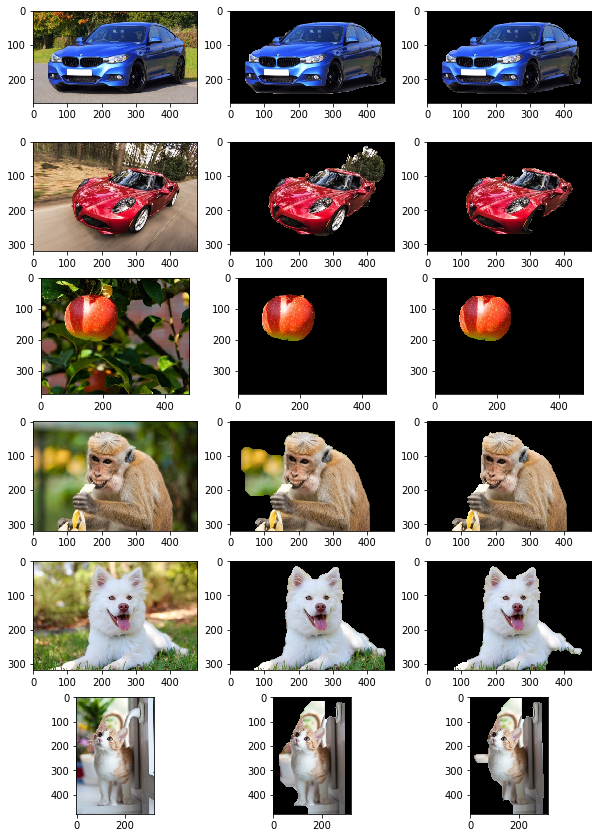

In [12]:
plt.figure(figsize=(10,15))
gaus_kernel = (7,7)
sigma = 3

bgr_imgs = [cv2.imread(f'tasks/object/{name}', cv2.IMREAD_COLOR) for name in sorted(os.listdir('tasks/object/'))]
cold_masks = [grab_cut(cv2.GaussianBlur(img, gaus_kernel, sigma)) for img in bgr_imgs]
hot_masks = grab_cut_iter(bgr_imgs, cold_masks, cv2.COLOR_BGR2RGB)    

for i in range(6):
    plt.subplot(2*3,3,3*i+1)
    img = cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.subplot(2*3,3,3*i+2)
    img_cold_masked = cv2.bitwise_and(img, img, mask=cold_masks[i])
    plt.imshow(img_cold_masked)
    
    plt.subplot(2*3,3,3*i+3)
    img_hot_masked = cv2.bitwise_and(img, img, mask=hot_masks[i])
    plt.imshow(img_hot_masked)

In [614]:
def update_mask(img, mask):
    c_x, c_y = scipy.ndimage.measurements.center_of_mass(mask)
    c_x = (np.round(c_x)).astype(np.int32)
    c_y = (np.round(c_y)).astype(np.int32)
    
    _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(cnt)
    
    retargeted_mask = np.zeros_like(mask) # true background
    retargeted_mask[y:y+h, x:x+w] = 2 # probable background
    retargeted_mask[mask==255] = 3 # probable foreground
        
    retargeted_mask = cv2.circle(retargeted_mask, (c_y, c_x), 50, 1, -1) # true foreground
    updated_mask = grab_cut(img, retargeted_mask)
    return updated_mask

"\nplt.figure(figsize=(15,10))\nfor i in range(6):\n    plt.subplot(6,2,2*i+1)\n    plt.imshow(retargeted_masks[i], cmap='gray')\n    plt.subplot(6,2,2*i+2)\n    plt.imshow(updated_masks[i], cmap='gray')\n"

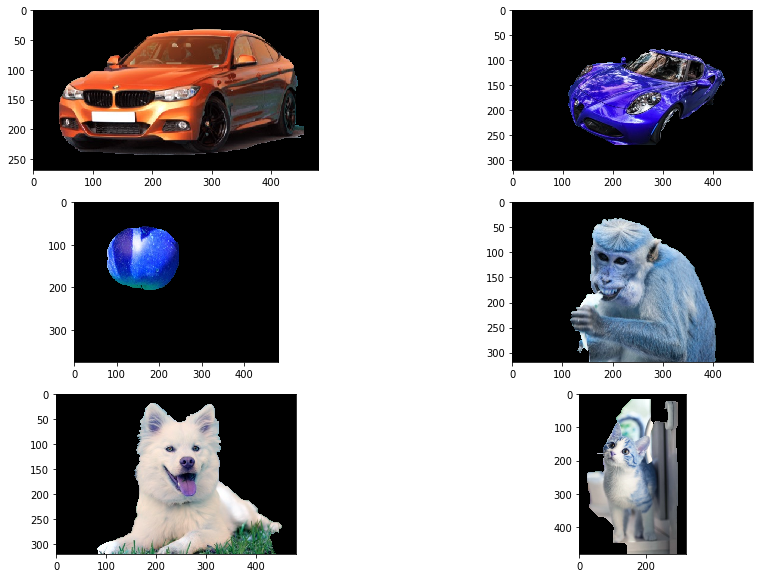

In [618]:
# retargeted_masks = []
updated_masks = [update_mask(img, mask) for img, mask in zip(bgr_imgs, cold_masks)]
for k in range(15):
    updated_masks = [update_mask(img, mask) for img, mask in zip(bgr_imgs, updated_masks)]    
#for k in range(10):
#    updated_masks = [update_mask(cv2.GaussianBlur(img, (13,13), 2), mask) for img, mask in zip(bgr_imgs, updated_masks)]

plt.figure(figsize=(15,10))   
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(cv2.bitwise_and(bgr_imgs[i],bgr_imgs[i],mask=updated_masks[i]), cmap='gray')
    
"""
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(6,2,2*i+1)
    plt.imshow(retargeted_masks[i], cmap='gray')
    plt.subplot(6,2,2*i+2)
    plt.imshow(updated_masks[i], cmap='gray')
"""

0 : [[ 99  26  89  89]
 [374  20  87  87]
 [ 45  33  98  98]
 [ 52  19 114 114]]
1 : [[312   0  79  79]
 [246 214  88  88]
 [133 150  80  80]
 [250  35  94  94]
 [200  24  96  96]
 [115 120 115 115]]
2 : [[243 159  76  76]
 [ 35 106 100 100]
 [162 218 107 107]
 [255 137 117 117]]
3 : ()
4 : [[198  65 112 112]
 [202 105 113 113]]
5 : [[ 12 106 114 114]]


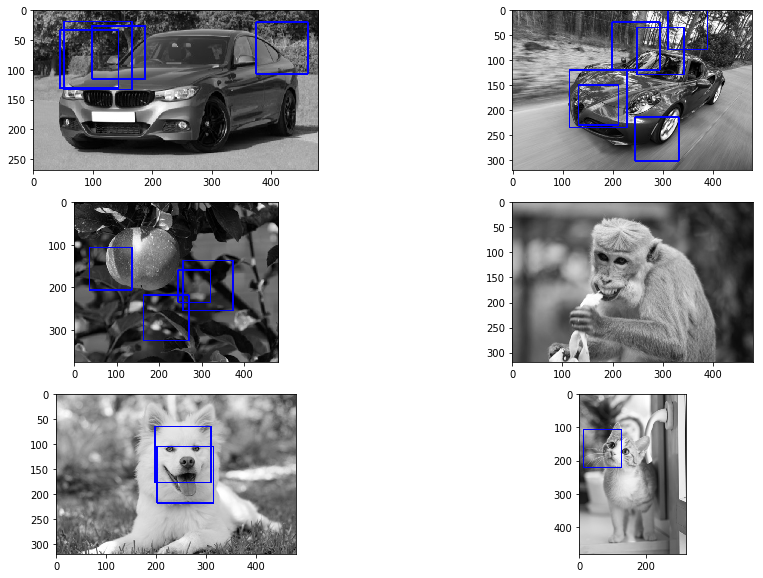

In [611]:
haar_cascade_cat_face = cv2.CascadeClassifier('/home/kostiantyn/anaconda3/envs/last_env/lib/python3.6/site-packages/cv2/data/haarcascade_frontalcatface.xml')
plt.figure(figsize=(15,10))
for k in range(6):
    # contrasted_img = cv2.equalizeHist(gray_imgs[k])
    contrasted_img = gray_imgs[k]
    blurred_img = cv2.GaussianBlur(contrasted_img, (7,7), 7)
    gray_img = cv2.cvtColor(gray_imgs[k].copy(), cv2.COLOR_GRAY2RGB)
    cat_faces_rects = haar_cascade_cat_face.detectMultiScale(blurred_img, 
                                                             scaleFactor=1.001,
                                                             minNeighbors=1, 
                                                             minSize=(75, 75),
                                                             maxSize=(125,125))
    print(k, ":", cat_faces_rects)
    
    for (i, (x, y, w, h)) in enumerate(cat_faces_rects):
        cv2.rectangle(gray_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.subplot(3,2,k+1)
    plt.imshow(gray_img, cmap='gray')

In [404]:
i = 1
curr_img = bgr_imgs[i]
kernel = np.ones((11,11), np.uint8)
eroded_mask = get_eroded_mask(hot_masks[i], kernel, iterations=2)
dilated_mask = cv2.dilate(hot_masks[i], kernel, iterations=4)
trimap = 0.5 * (eroded_mask.astype(np.float32) + dilated_mask.astype(np.float32))
alpha, cutout = alpha_matting(curr_img, trimap)


solving linear system...


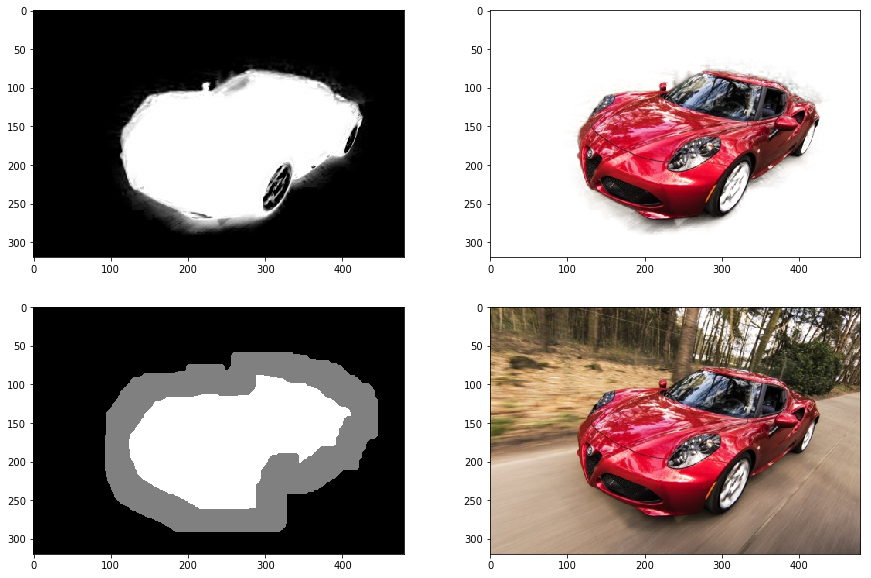

In [405]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(alpha, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(cutout)
plt.subplot(2,2,3)
plt.imshow(trimap, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(curr_img[...,::-1])

In [297]:
def active_contour(alpha = 0.0015, beta = 1., gamma = 0.001, w_line = 1., w_edge = 1.):
    bc = 'periodic'
    obj_rough_outline = []
    obj_refined_outline = []
    
    plt.figure(figsize=(15,10))
    for i, (img, mask) in enumerate(zip(bgr_imgs, cold_masks)):
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, _, img = cv2.split(img)
        img = cv2.GaussianBlur(img, (3,3), 1)
        _, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key = cv2.contourArea)
        obj_rough_outline.append(cnt)
        init = cnt[:, 0, :]
        snake = skimage.segmentation.active_contour(img, init, bc=bc, alpha=alpha, beta=beta, gamma=gamma, w_line=w_line, w_edge=w_edge)
        obj_refined_outline.append(snake)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(img, [cnt], 0, (0, 255, 0), thickness=2)
        cv2.drawContours(img, [snake[:, np.newaxis, :].astype(np.int32)], 0, (255, 0, 0), thickness=2)
        plt.subplot(3, 2, i+1)
        plt.imshow(img)

cont_plot = interactive(active_contour, alpha=(0.0, 1.0, 0.0005), beta=(0.0, 20.0, 0.1), gamma=(0.0001, 0.01, 0.0001), w_line=(-10., 10., 0.1), w_edge=(-10., 10., 0.1))
cont_plot

interactive(children=(FloatSlider(value=0.0015, description='alpha', max=1.0, step=0.0005), FloatSlider(value=…

In [27]:
cnt.shape

(194, 1, 2)

In [3]:
def blur_score(img):
    laplacian = cv2.Laplacian(img, cv2.CV_8UC1, ksize=11)
    # ret, th = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    th = cv2.adaptiveThreshold(laplacian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    return th

In [422]:
def get_snake(img, rect, **kwargs):
    init = rect[:,0,:]
    snake = 
    return snake

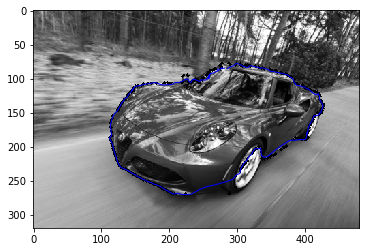

In [429]:
j = 1
img = gray_imgs[j].copy()
snake = get_snake(img, mask_rects_contour[j][2])
cv2.drawContours(img, mask_rects_contour[j][2], -1, (0,255,0), 3)
plt.imshow(img, cmap='gray')

plt.plot(snake[:, 0], snake[:, 1], '-b', lw=1)

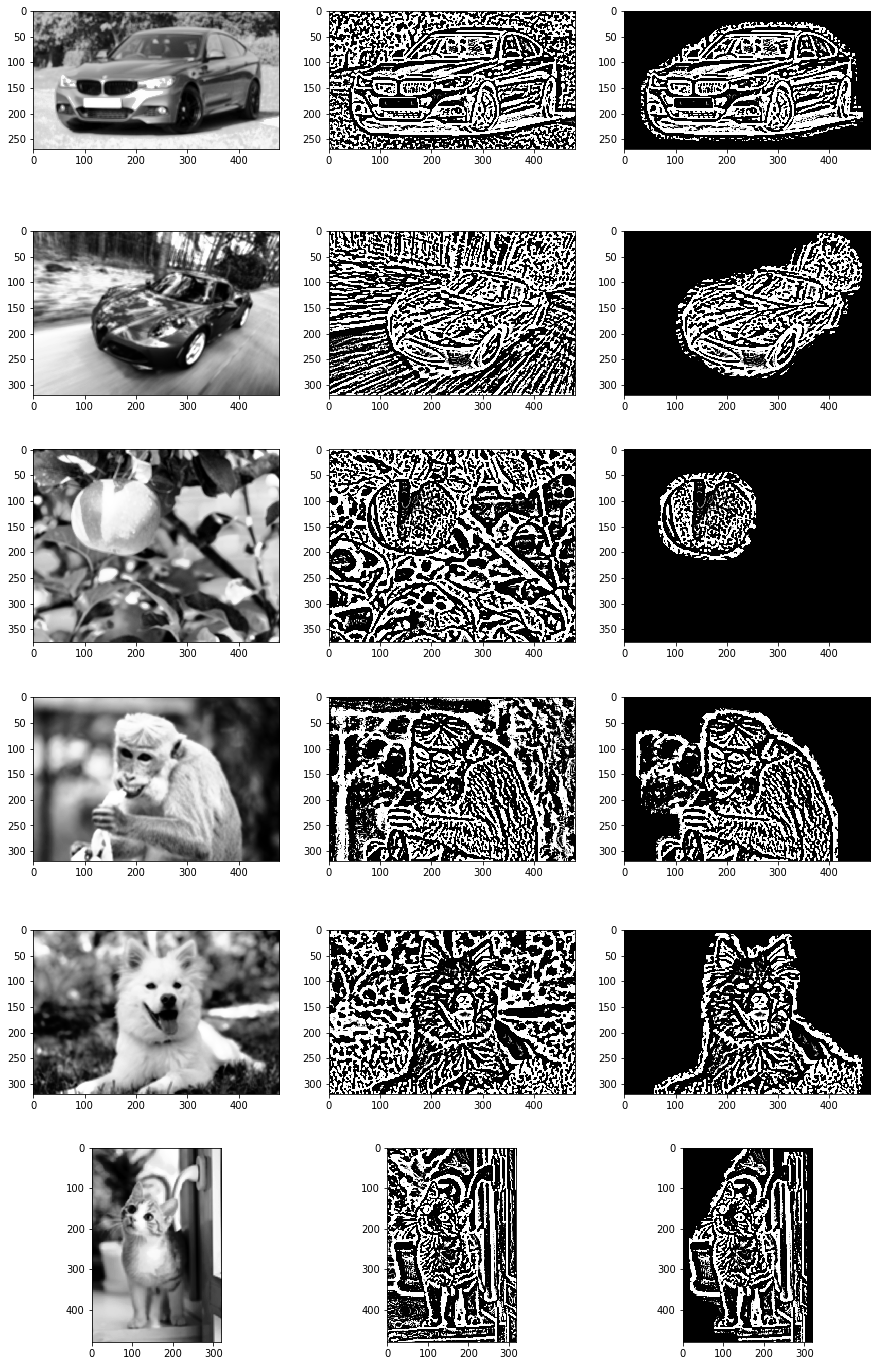

In [160]:
plt.figure(figsize=(15,25))
for i in range(6):
    img = yuv_imgs[i][...,0]
    img = cv2.GaussianBlur(img, (5,5), 30)
    img = cv2.equalizeHist(img)
    laplacian = cv2.Laplacian(img, cv2.CV_8UC1, ksize=7)
    
    plt.subplot(6,3,1+3*i)
    plt.imshow(img, cmap='gray')
    plt.subplot(6,3,2+3*i)
    plt.imshow(laplacian, cmap='gray')
    plt.subplot(6,3,3+3*i)
    kernel = np.ones((11,11),np.uint8)
    mask = cv2.dilate(cold_masks[i], kernel, iterations=2)
    plt.imshow(cv2.bitwise_and(laplacian, laplacian, mask=mask), cmap='gray')

In [152]:
cutted_laplacian = cv2.bitwise_and(laplacian, laplacian, mask=mask)

In [147]:
cutted_laplacian = cv2.morphologyEx(cutted_laplacian, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations=2)

In [154]:
ret, labels = cv2.connectedComponents(cutted_laplacian)
label_hue = np.uint8(179*labels/np.max(labels)) 
blank_ch = 255*np.ones_like(label_hue) 
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue==0] = 0

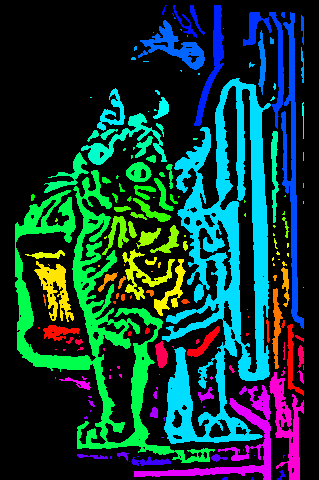

<Figure size 720x720 with 0 Axes>

In [159]:
plt.figure(figsize=(10,10))
#plt.imshow(labeled_img)
Image.fromarray(labeled_img)

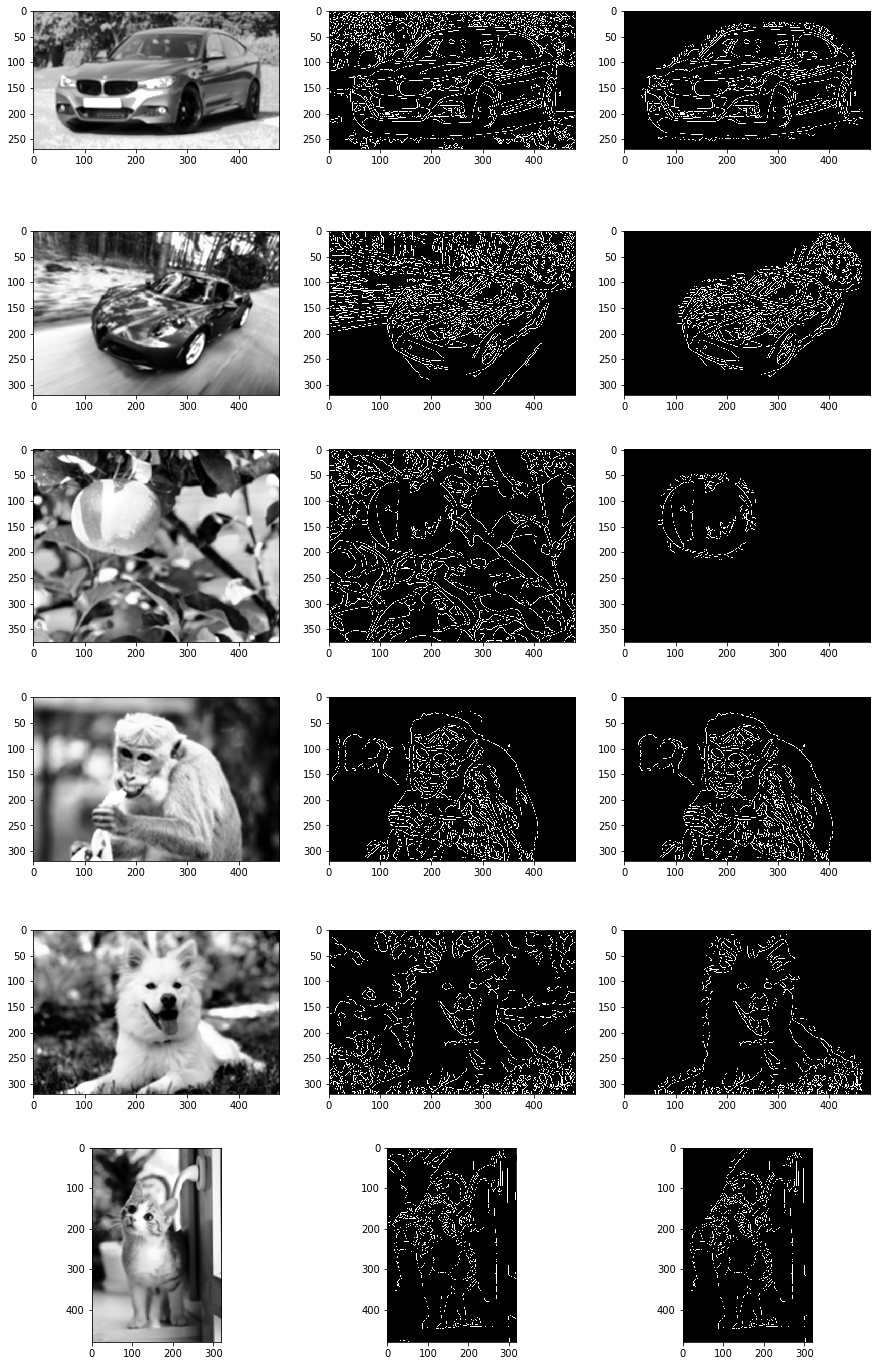

In [79]:
plt.figure(figsize=(15,25))
for i in range(6):
    img = yuv_imgs[i][...,0]
    img = cv2.GaussianBlur(img, (5,5), 3)
    img = cv2.equalizeHist(img)
    plt.subplot(6,3,1+3*i)
    plt.imshow(img, cmap='gray')
    plt.subplot(6,3,2+3*i)
    canny = cv2.Canny(img, 1, 100)
    plt.imshow(canny, cmap='gray')
    plt.subplot(6,3,3+3*i)
    kernel = np.ones((11,11),np.uint8)
    mask = cv2.dilate(cold_masks[i], kernel, iterations=2)
    plt.imshow(cv2.bitwise_and(canny, canny, mask=mask), cmap='gray')

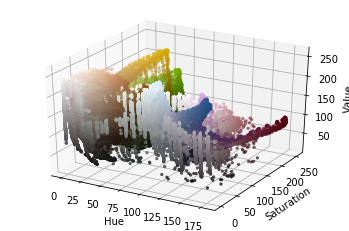

In [84]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

i = 5

pixel_colors = cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2RGB).reshape((-1, 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

h, s, v = cv2.split(hsv_imgs[i])
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [28]:
import scipy.cluster.hierarchy as hcluster

def hclusters(bgr_img, thresh = 15):
    np.random.seed(42)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    data = np.stack((h.flatten(), s.flatten()), axis=1)
    sample_size = data.shape[0] // 10
    idx = np.random.choice(data.shape[0], sample_size, replace=False)
    sample = data[idx]
    clusters = hcluster.fclusterdata(sample, thresh, criterion="distance")
    print(clusters.max())
    return clusters, idx

In [29]:
clusters_id = [hclusters(img) for img in bgr_imgs]

6
11
15
2
5
1


In [166]:
colors = em_color(bgr_imgs[5], ncolors=12)

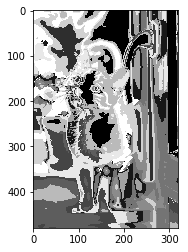

In [167]:
plt.imshow(colors, cmap='gray')

In [667]:
def connected_left(gaus_size=9, gaus_sigma=2, laplace_size=7, dilate_size=11, connectivity=4):
    plt.figure(figsize=(15,10))
    for j in range(6):
        pca = decomposition.PCA(n_components=3)
        res = pca.fit_transform(bgr_imgs[j].reshape(-1,3)).reshape(bgr_imgs[j].shape[0], bgr_imgs[j].shape[1], 3)
        ch1, ch2, ch3 = cv2.split(res)
        ch1 = cv2.GaussianBlur(ch1, (gaus_size,gaus_size), gaus_sigma)
        ch1_normed = (255*(ch1 - ch1.min())/(ch1.max() - ch1.min())).astype(np.uint8)

        laplaced = cv2.Laplacian(ch1_normed, cv2.CV_8UC1, ksize=laplace_size)
        mask = cv2.dilate(cold_masks[j], np.ones((dilate_size,dilate_size), dtype=np.uint8))
        cutted_laplacian = cv2.bitwise_and(laplaced,laplaced,mask=mask)

        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cutted_laplacian, connectivity=connectivity)
        sizes = stats[:, -1]

        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]

        hole_mask = np.zeros(output.shape)
        hole_mask[output == max_label] = 255
        plt.subplot(3,2,j+1)
        plt.imshow(hole_mask, cmap='gray')
        
connect = interactive(connected_left, gaus_size=(3,31,2), gaus_sigma=(1., 30., 0.5), laplace_size=(3,31,2), dilate_size=(3,31,2), connectivity=(4,8,4))
connect

interactive(children=(IntSlider(value=9, description='gaus_size', max=31, min=3, step=2), FloatSlider(value=2.…

In [656]:
labels.max()

78

In [279]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [299]:
def f(i=5, ksize=3, gaus_ksize=3, sigma=3.0):
    from sklearn import decomposition
    pca = decomposition.PCA(n_components=3)
    res = pca.fit_transform(bgr_imgs[i].reshape(-1,3)).reshape(bgr_imgs[i].shape[0], bgr_imgs[i].shape[1], 3)
    ch1, ch2, ch3 = cv2.split(res)
    ch1 = cv2.GaussianBlur(ch1, (gaus_ksize,gaus_ksize), sigma)
    ch1_normed = (255*(ch1 - ch1.min())/(ch1.max() - ch1.min())).astype(np.uint8)
    
    laplaced = cv2.Laplacian(ch1_normed, cv2.CV_8UC1, ksize=ksize)
    mask = cv2.dilate(cold_masks[i], np.ones((11,11), dtype=np.uint8))
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(laplaced, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(cv2.bitwise_and(laplaced,laplaced,mask=mask), cmap='gray')

int_plot = interactive(f, i=(0,5,1), ksize=(3, 31, 2), gaus_ksize=(3, 31, 2), sigma=(1.0, 100.0, 1.0))
int_plot

interactive(children=(IntSlider(value=5, description='i', max=5), IntSlider(value=3, description='ksize', max=…

In [460]:
from sklearn import decomposition
i = 5
pca = decomposition.PCA(n_components=3)
res = pca.fit_transform(bgr_imgs[i].reshape(-1,3)).reshape(bgr_imgs[i].shape[0], bgr_imgs[i].shape[1], 3)
ch1, ch2, ch3 = cv2.split(res)
ch1 = cv2.GaussianBlur(ch1, (9,9), 2.)
ch1_normed = (255*(ch1 - ch1.min())/(ch1.max() - ch1.min())).astype(np.uint8)
ch2 = cv2.GaussianBlur(ch2, (9,9), 2.)
ch2_normed = (255*(ch2 - ch2.min())/(ch2.max() - ch2.min())).astype(np.uint8)
ch3 = cv2.GaussianBlur(ch3, (9,9), 2.)
ch3_normed = (255*(ch3 - ch3.min())/(ch3.max() - ch3.min())).astype(np.uint8)

laplaced = cv2.Laplacian(ch1_normed, cv2.CV_8UC1, ksize=7)
mask = cv2.dilate(cold_masks[i], np.ones((11,11), dtype=np.uint8))
out_res = cv2.bitwise_and(laplaced,laplaced,mask=mask)

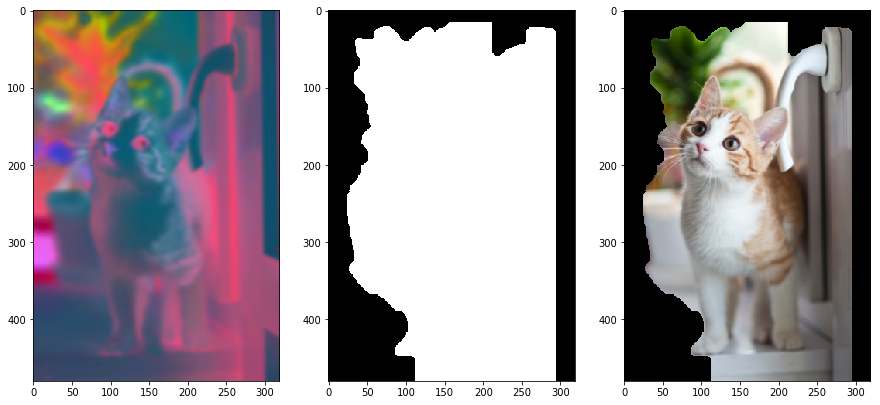

In [461]:
res_normed = np.stack((ch1_normed, ch2_normed, ch3_normed), axis=2)
res_mask = grab_cut(res_normed)
plt.figure(figsize=(15,10))
#plt.imshow(res_normed[..., 0], cmap='gray')
plt.subplot(1,3,1)
plt.imshow(res_normed)
plt.subplot(1,3,2)
plt.imshow(res_mask, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(cv2.bitwise_and(bgr_imgs[i][...,::-1], bgr_imgs[i][...,::-1], mask=res_mask), cmap='gray')

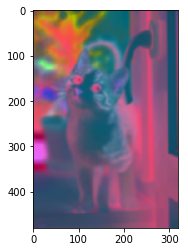

In [334]:
def ff(morph_size=3, iterations=1, repeats=1):
    kernel = np.ones((morph_size,morph_size),dtype=np.uint8)
    for i in range(repeats):
        res2 = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, iterations=iterations)
        res2 = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel, iterations=iterations)
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    plt.imshow(res2, cmap='gray')

cat = interactive(ff, morph_size=(3,31,2), iterations=(1,20,1), repeats=(1,20,1))
cat

interactive(children=(IntSlider(value=3, description='morph_size', max=31, min=3, step=2), IntSlider(value=1, …

In [346]:
kernel = np.ones((5,5),dtype=np.uint8)
res2 = cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel, iterations=1)
res2 = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel, iterations=1)

In [347]:
_, cntrs, _ = cv2.findContours(res2, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

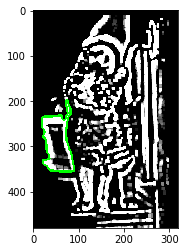

In [348]:
res2_copy = res2.copy()
res2_copy = cv2.cvtColor(res2_copy, cv2.COLOR_GRAY2BGR)
cnt = max(cntrs, key = cv2.contourArea)
cv2.drawContours(res2_copy, [cnt], -1, (0, 255, 0), 3)
plt.imshow(res2_copy)

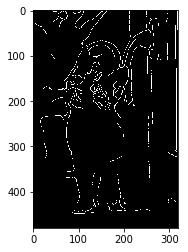

In [250]:
plt.imshow(cv2.Canny(ch1_normed, 1, 100), cmap='gray')

In [208]:
yuv = yuv_imgs[5]
yuv[...,0] = cv2.equalizeHist(yuv[...,0])
bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

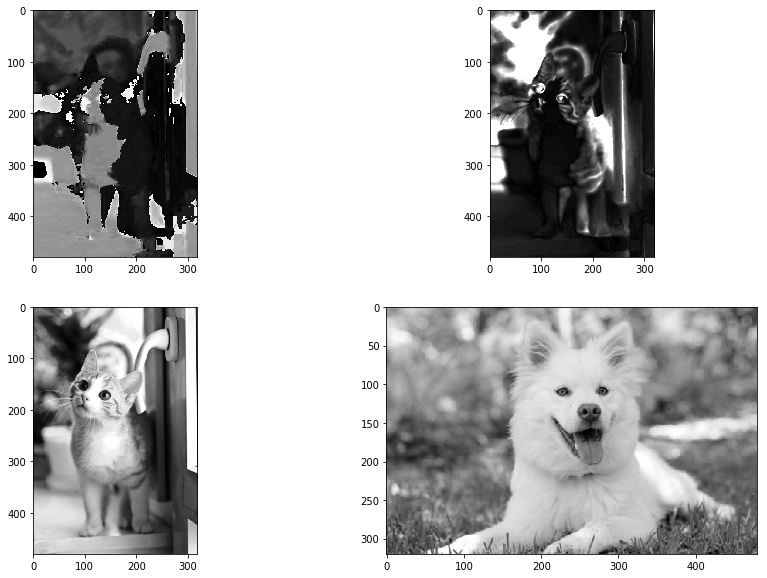

In [209]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(hsv[...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(hsv[...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(hsv[...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[4], cv2.COLOR_BGR2GRAY), cmap='gray')

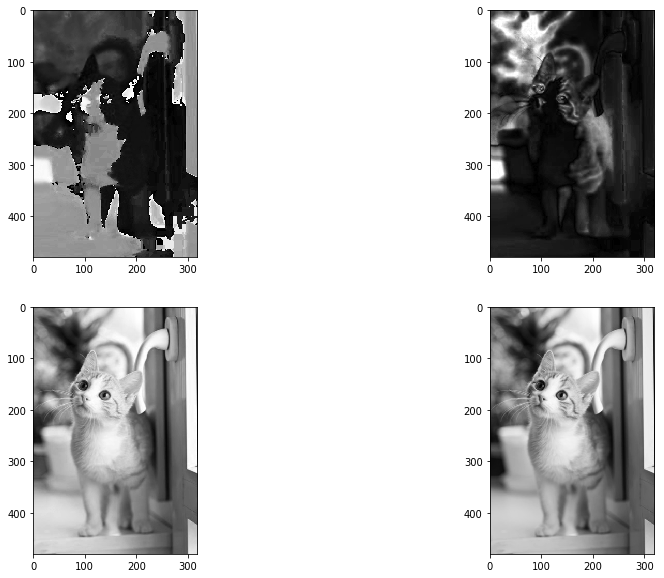

In [142]:
i=5
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(hsv_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(hsv_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(hsv_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')

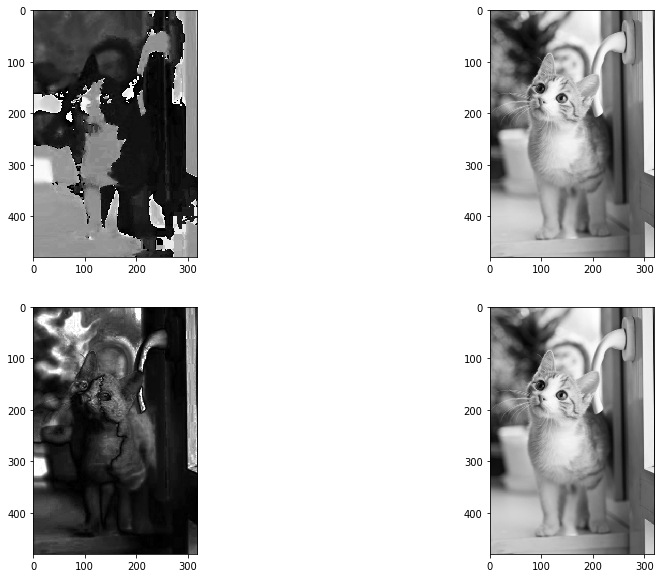

In [210]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(hls_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(hls_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(hls_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')

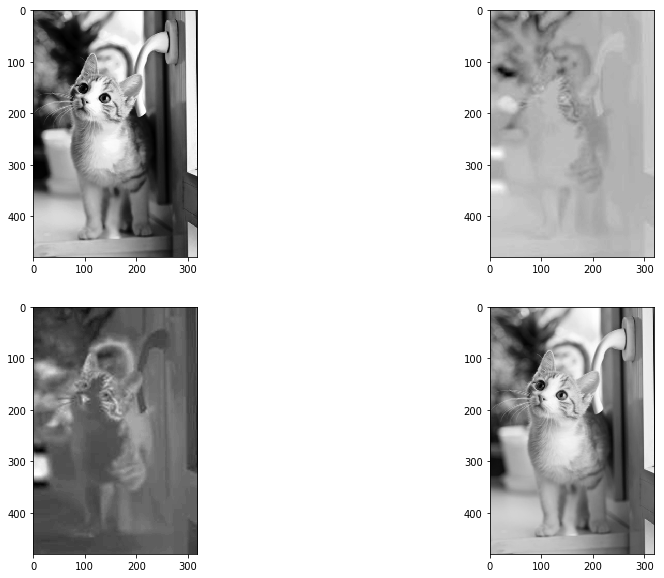

In [211]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(yuv_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(yuv_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(yuv_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')

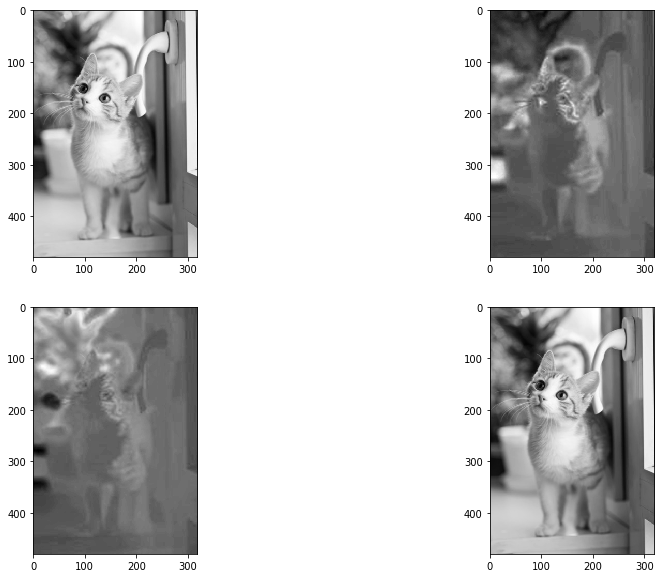

In [212]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(luv_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(luv_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(luv_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')

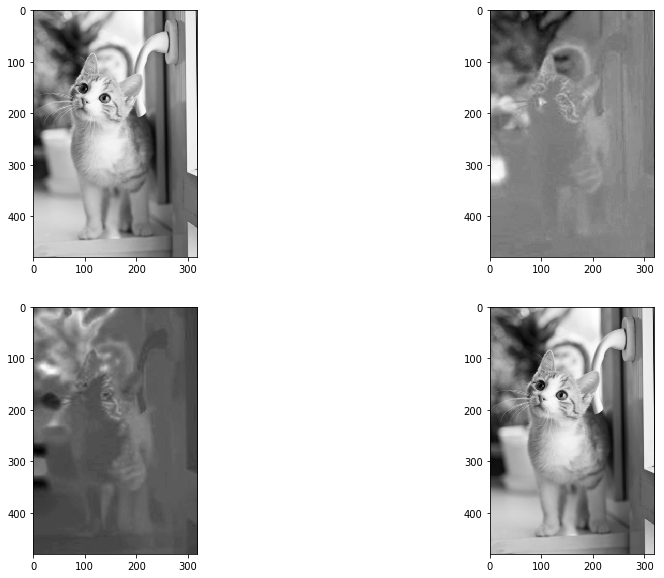

In [213]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(lab_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(lab_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(lab_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')

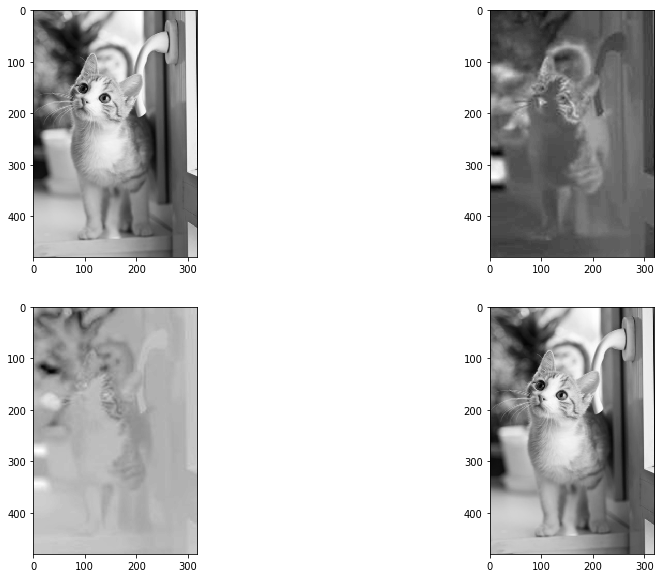

In [214]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(ycrcb_imgs[i][...,0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(ycrcb_imgs[i][...,1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(ycrcb_imgs[i][...,2], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(bgr_imgs[i], cv2.COLOR_BGR2GRAY), cmap='gray')